# NE 204 Lab 1 - Fitting Trapezoidal Filter Params

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models import HoverTool
import time
import pandas as pd

# import tool repo
import sys

sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, TrapezoidalFilter

# sys.path.append('/Users/kalie/courses/ne204/lab/lab_partners/ne204lib')
# from kit204lib.spectrum import Spectrum
# from kit204lib.filters import jordanov_filter, cooper_filter
# from kit204lib.analyze_waveform import plot_pulses, fit_tau
# from kit204lib.make_histogram import make_histogram
# from scipy.signal import find_peaks, peak_prominences

In [3]:
print('cs calibration')
f_name = './data/2022_10_28/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')


In [ ]:
cs_bkg = subtract_baseline(cs)

# fit tau

In [5]:
# first downsample data a reasonable amount
cs_down = cs_bkg[::100]
cs_down.shape

(9131, 5000)

In [ ]:
tauvals = fit_taus(cs_down)
tauvals.mean(), tauvals.std()

<IPython.core.display.Javascript object>


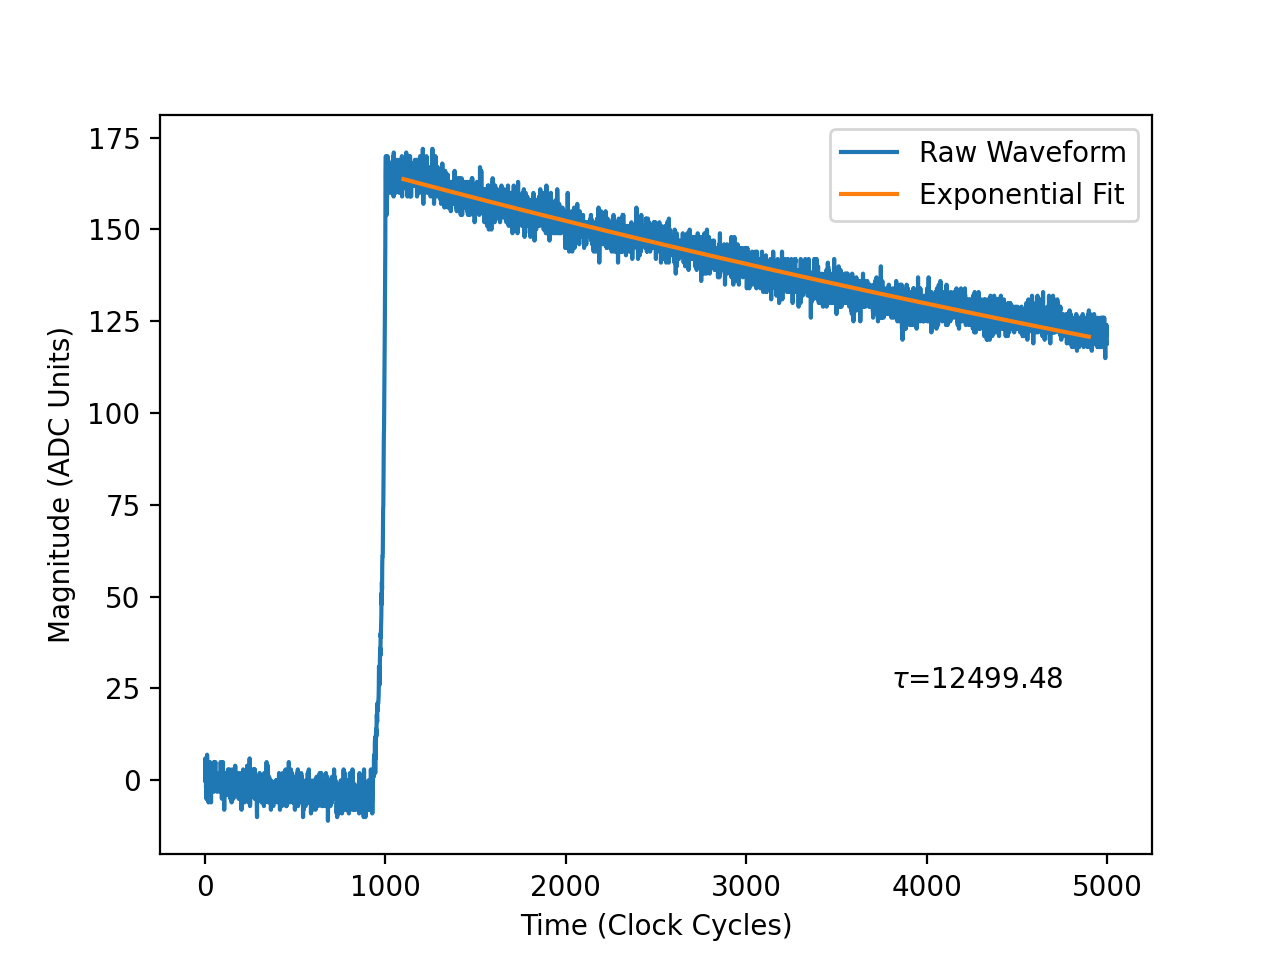

12499.475104450019

In [6]:
# example of good fit
fit_tau(cs_down[0],show_plot=True)

In [ ]:
# we want to remove piled up pulses from our tau fit
# piled up pulses typically have large tau, or negative tau
mask = tauvals < 2e4 # less than 15000
mask *= tauvals > 5e3 # at least 1000
good_tau_pulses = cs_down[mask]

tau_fixed = fit_taus(good_tau_pulses)
bad_tau_pulses = cs_down[~mask]
good_tau_pulses = cs_down[mask]
bad_tau_pulses.shape

<IPython.core.display.Javascript object>


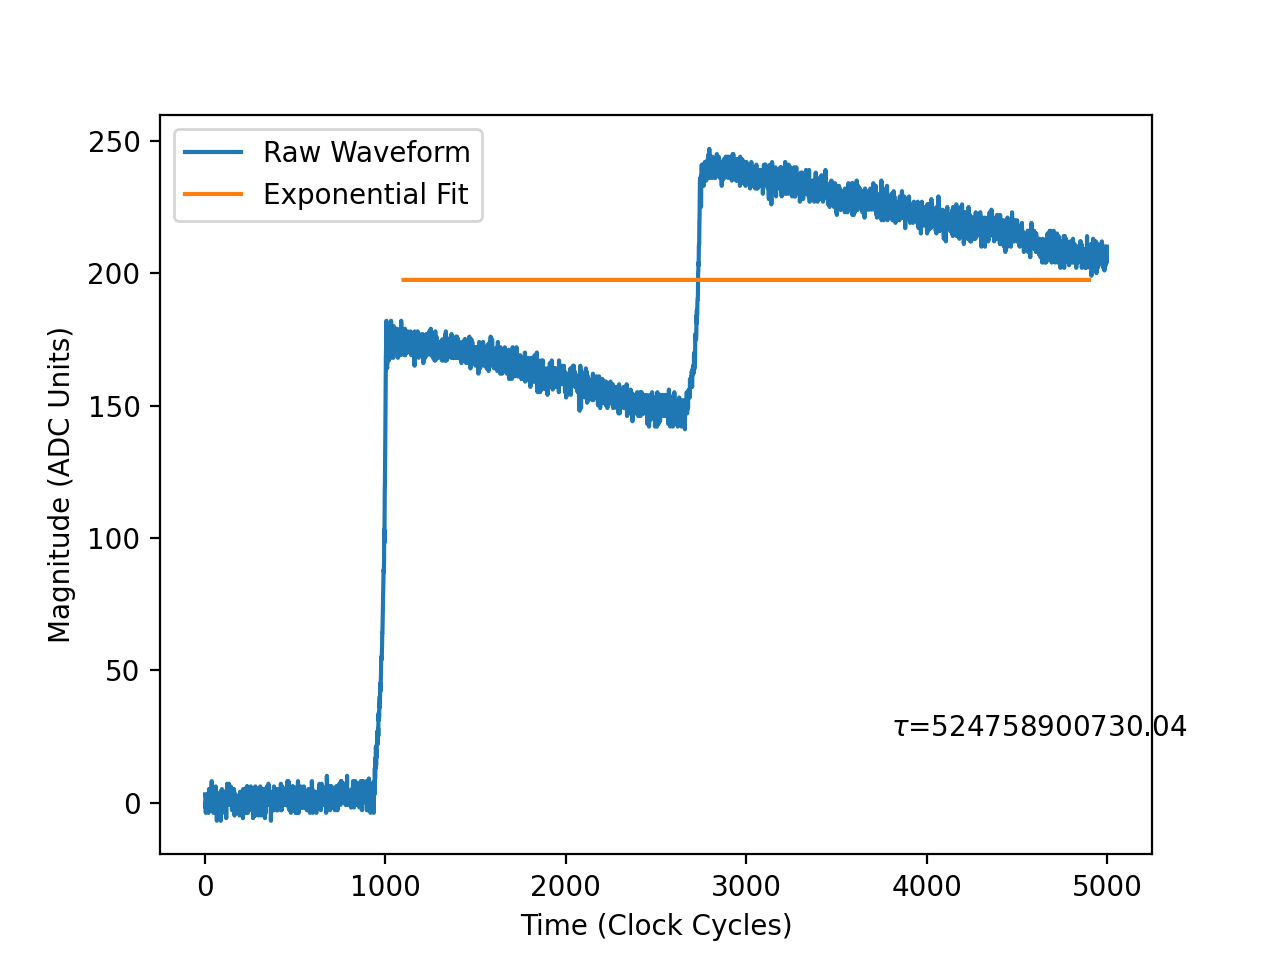

524758900730.0444

In [7]:
fit_tau(bad_tau_pulses[5],show_plot=True,plot_save_name='../figs/tau_fit_pileup.png')

In [ ]:
plt.figure()
for i in range(len(bad_tau_pulses)):
    plt.plot(bad_tau_pulses[i])
plt.show()

<IPython.core.display.Javascript object>


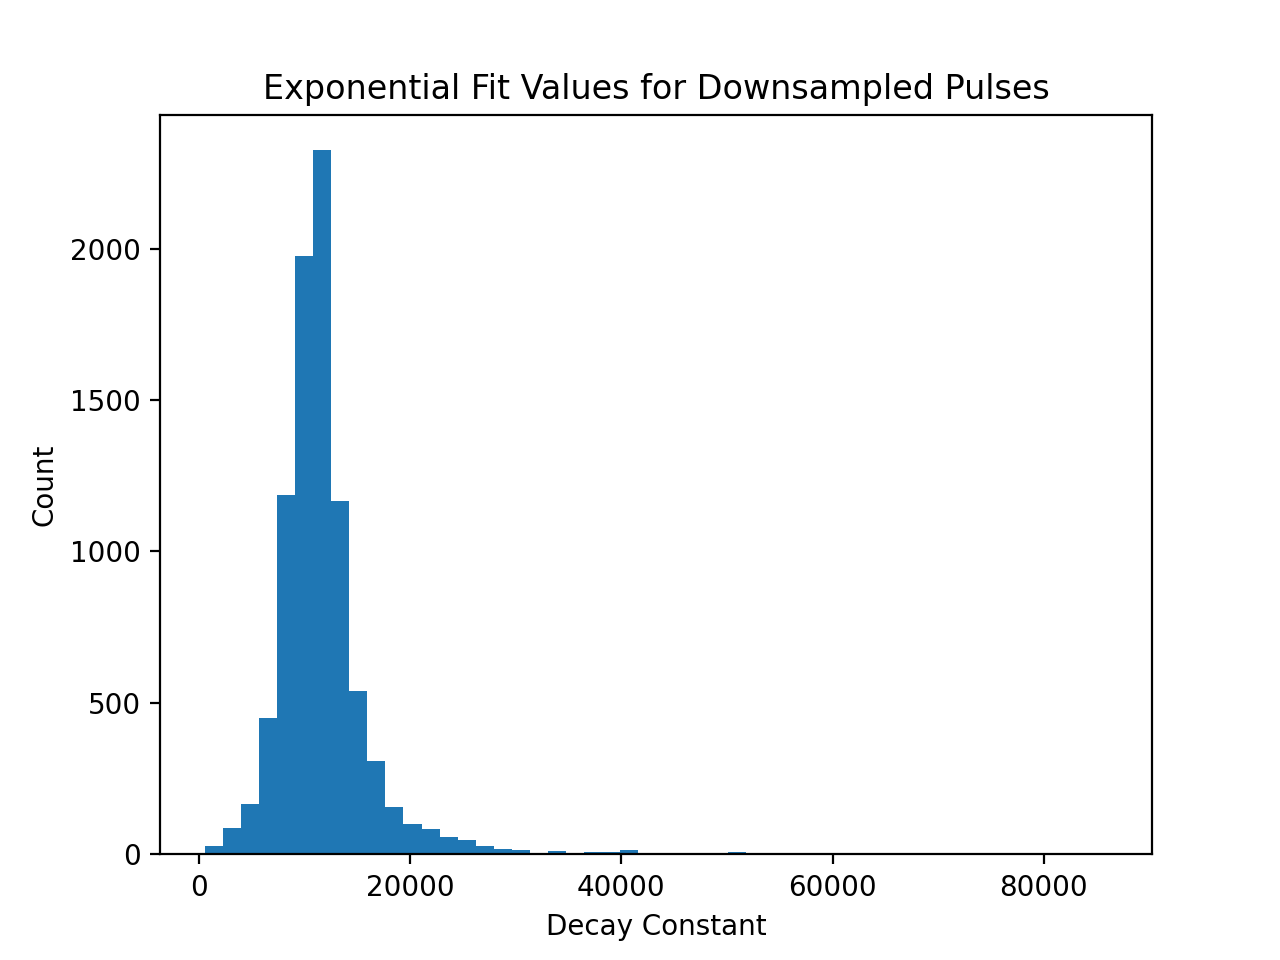

In [16]:
plt.figure()
plt.hist(tau_fixed,bins=50)
plt.xlabel('Decay Constant')
plt.ylabel('Count')
plt.title('Exponential Fit Values for Downsampled Pulses')
plt.show()

In [8]:
tau = tau_fixed.mean()
peaking_time = 100 * 4 * 10**(-9)#1.6e-6/2
#peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 10  #6.4e-6/4

tau, peaking_time, gap_time

mean and variance: 5641226553.945128 1.42101424495566e+21


In [ ]:
# # use tau to filter pileup out of data
# all_taus = fit_taus(cs_bkg)

# mask = all_taus < 2e4
# mask *= all_taus > 1e3
# filtered_cal_pulses = cs_bkg[mask]
# print(filtered_cal_pulses.shape)

# filtered_cal_pulses_down = filtered_cal_pulses[::10]
# print(filtered_cal_pulses_down.shape)

In [ ]:
plt.figure()

iter = 0
for idx, val in enumerate(trap_heights):
    if val > 4.7 * 10**(16):
        if val < 5.1 * 10 ** (16):
            iter = iter + 1
            if iter < 50:
                plt.plot(filtered_waves[idx])
                #iter = iter + 1
plt.show()

In [ ]:
pileups = np.ones(len(filtered_waves), dtype=bool)
for idx, val in enumerate(filtered_waves):
    if not all(i <= 10**15 for i in val[2000:]):
        pileups[idx] = False
    

In [ ]:
def determine_rise(signal, sigma=8, window=20, offset=100):
    # Input filtered signal, returns index of start of rise on pulse
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)

    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))

    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)

    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break

    return int(rise_start-offset)

In [ ]:
determine_rise(calibration_bkg[0])

In [ ]:
def dkl(signal, i, k, l, w):
    """
    Calculates dkl value given a signal,
        i = index of start of rise
        k = peaking time
        l = peaking time + gap time
        w = width of window to sample on pulse (trapezoid output width)
    """
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl

## To do  - get full pipeline working to optimize peak and gap time